In [29]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

base_image_path = keras.utils.get_file("yeni.jpg",  "https://images.unsplash.com/photo-1593291600904-660bbd59a758?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1170&q=80")
result_prefix = "yeni_dream"

# Bunlar, aktivasyonu en üst düzeye çıkarmaya çalıştığımız katmanların adı
# ve en üst düzeye çıkarmaya çalıştığımız son kayıptaki ağırlıklardır

# yeni görsel efektler elde etmek için bu ayarları düzenleyebilirsiniz
layer_settings = {"mixed4":2.0, "mixed5":3.5, "mixed6":2.5, "mixed7":3.0}

# Bu hiperparametrelerle oynamak da yeni efektler elde etmenizi sağlar
step = 0.02 # gradyan çıkış adım sayısı
num_octav = 3 # gradyan yükselmesinin çalıştırılacağı ölçek sayısı
octave_scale = 1.3 # ölçekler arasındaki boyut oranı
iterations = 21 # ölçek başına çıkış adım sayısı
max_loss = 15.0 


*Giriş Görüntüsü*

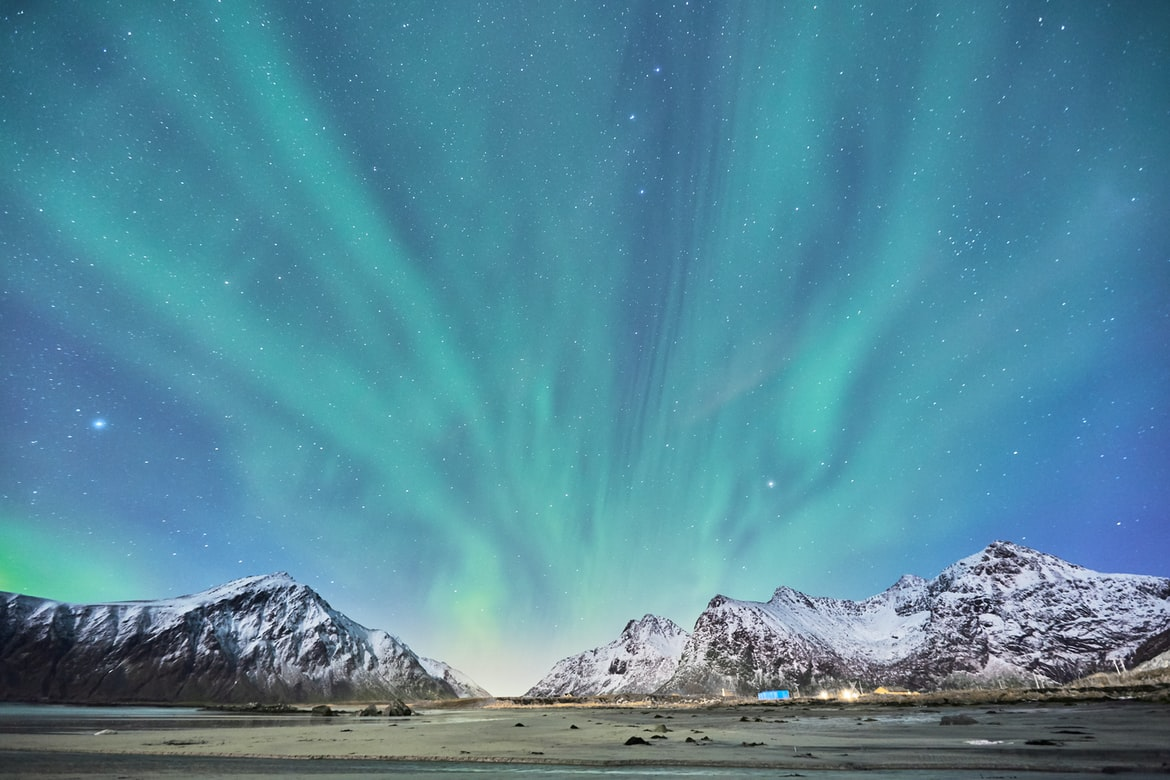

In [22]:
from IPython.display import Image , display
display(Image(base_image_path))

*Bazı görüntü önişleme / yeniden işleme yardımcı programlarını ayarlayalım*

In [23]:
def preprocess_image(image_path):
  # Resimleri uygun dizilere açmak, yeniden boyutlandırmak ve biçimlendirmek için util işlevi
  img = keras.preprocessing.image.load_img(image_path) # resmin dosya yolu alınır
  img = keras.preprocessing.image.img_to_array(img) # resim bir diziye çevrilir
  img = np.expand_dims(img, axis=0) # resmin boyutlandırma işlemleri yapılır
  img = inception_v3.preprocess_input(img) # resim inception_v3 ün girişine uygun olarak ayarlanır

  return img

def deprocess_image(x):
  # numpy dizisini geçerli bir görüntüye dönüştürmek için util işlevi
  x = x.reshape((x.shape[1],x.shape[2],3))
  # InceptionV3 önişlemesini geri alma
  x /= 2.0
  x += 0.5
  x *= 255.0
  # uint8 e dönüştürülür ve geçerli aralığa göre clip işlemi yapılır range [0,255]
  x = np.clip(x,0,255).astype("uint8")

  return x

## Deep Dream Kaybının Hesaplanması

*İlk olarak, bir giriş görüntüsü verilen hedef katmanlarımızın aktivasyonunu almak için bir özellik çıkarma modeli oluşturalım*

In [24]:
# Önceden eğitilmiş ImageNet ağırlıklarıyla dolu bir InceptionV3 modeli oluşturalım
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

# Her 'anahtar' katmanın sembolik çıktılarını alalım
outputs_dict = dict([(layer.name,layer.output)
                      for layer in [model.get_layer(name) for name in layer_settings.keys()]
                     ])
# Her hedef katman için etkinleştirme değerlerini döndüren bir model oluşturalım (dict  olarak)
feature_extractor = keras.Model(inputs = model.inputs, outputs = outputs_dict)

*Gerçek kayıp hesaplaması çok basittir*

In [25]:
def compute_loss(input_image):
  features = feature_extractor(input_image)
  # kaybı başlat
  loss = tf.zeros(shape=())
  for name in features.keys():
    coeff = layer_settings[name]
    activation = features[name]
    # sınırda olmayan pikselleri yalnızca kayda dahil ederek kenarlık yapaylıklarından kaçınırız
    scaling = tf.reduce_prod(tf.cast(tf.shape(activation),"float32"))
    loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    return loss

*Bir oktav için gradyan çıkış döngüsünü ayarlayalım*

In [26]:
@tf.function
def gradient_ascent_step(img, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(img)
    loss = compute_loss(img)
    # gradyanların hesaplanması
    grads = tape.gradient(loss,img)
    # gradyanların normalize edilmesi
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)),1e-6)
    img += learning_rate * grads

    return loss,img

def gradient_ascent_loop(img,iterations,learning_rate,max_loss=None):
  for i in range(iterations):
    loss, img =  gradient_ascent_step(img,learning_rate)
    if max_loss is not None and loss > max_loss:
      break
    print("... Loss value at step %d : %.2f " % (i,loss))

  return img

*Farklı oktavlar üzerinde yineleyerek eğitim döngüsünü çalıştıralım*

In [27]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1,num_octav):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[:: -1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)

for i, shape in enumerate(successive_shapes):
  print("Processing octave %d with shape %s " % (i,shape))
  img = tf.image.resize(img,shape)
  img = gradient_ascent_loop(img,iterations=iterations,learning_rate=step,max_loss=max_loss)

  # görüntü orijinal shape e  gelene kadar resize işlemi yapılır
  upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img,shape)
  same_size_original = tf.image.resize(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img

  img += lost_detail
  shrunk_original_img = tf.image.resize(original_img,shape)


keras.preprocessing.image.save_img(result_prefix + ".png" , deprocess_image(img.numpy()))

Processing octave 0 with shape (461, 692) 
... Loss value at step 0 : 0.27 
... Loss value at step 1 : 0.33 
... Loss value at step 2 : 0.51 
... Loss value at step 3 : 0.72 
... Loss value at step 4 : 0.94 
... Loss value at step 5 : 1.19 
... Loss value at step 6 : 1.41 
... Loss value at step 7 : 1.63 
... Loss value at step 8 : 1.84 
... Loss value at step 9 : 2.08 
... Loss value at step 10 : 2.32 
... Loss value at step 11 : 2.52 
... Loss value at step 12 : 2.75 
... Loss value at step 13 : 2.96 
... Loss value at step 14 : 3.21 
... Loss value at step 15 : 3.44 
... Loss value at step 16 : 3.65 
... Loss value at step 17 : 3.90 
... Loss value at step 18 : 4.15 
... Loss value at step 19 : 4.43 
... Loss value at step 20 : 4.60 
Processing octave 1 with shape (600, 900) 
... Loss value at step 0 : 0.76 
... Loss value at step 1 : 1.46 
... Loss value at step 2 : 1.91 
... Loss value at step 3 : 2.28 
... Loss value at step 4 : 2.63 
... Loss value at step 5 : 2.99 
... Loss val

*Sonuçları görselleştirelim*

In [28]:
display(Image(result_prefix + ".png"))

Output hidden; open in https://colab.research.google.com to view.